# Importing package

In [7]:
%load_ext autoreload
%autoreload 2
import sys
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
sys.path.append('..')
filedirectory = "//Users//joancaceres//Documents//FERBO//FB_W10_S4//run3//"
from src.utilities import *
from scipy.optimize import differential_evolution
from src.jja import jja_resonances, jja_eigensys, C_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets

In [8]:
datasets = {
    'sts_power':    476,
    'tts_gain':     1453,
    'tts_gain2':    1587,
}

In [9]:
data = {}
for key, datanumber in tqdm(datasets.items()):
    data[key] = load_data(filedirectory + "FBW10S4_" +str(datanumber))
    if 'freq' in data[key]:
        data[key]['freq'] *= 1e-9

  0%|          | 0/3 [00:00<?, ?it/s]

# Single tone spectroscopy

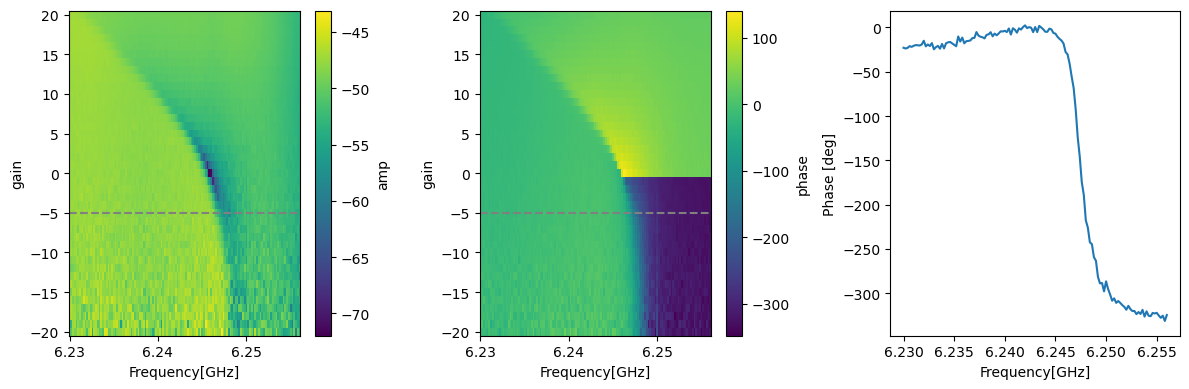

In [10]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

resonator_gain = data['tts_gain']['parameters']['resonator_gain']
resonator_freq = data['tts_gain']['parameters']['resonator_frequency']

plot3D(
    data_dict=data['sts_power'],
    x_key='freq',
    y_key='gain',
    z_key='amp',
    ax=ax[0],
    fig=fig,
)
ax[0].axhline(y=resonator_gain,linestyle='dashed', color='gray')

plot3D(
    data_dict=data['sts_power'],
    x_key='freq',
    y_key='gain',
    z_key='phase',
    ax=ax[1],
    fig=fig,
    )

ax[1].axhline(y=resonator_gain,linestyle='dashed', color='gray')

idx = np.where(data['sts_power']['gain'] == -5)[0][0]
ax[2].plot(data['sts_power']['freq'][idx,:], data['sts_power']['phase'][idx,:])
ax[2].set_ylabel('Phase [deg]')

for ax in ax.flatten():
    ax.set_xlabel('Frequency[GHz]')
fig.tight_layout()
plt.show()

# Two tone spectroscopy

Values

In [11]:
resonances = np.array([6.249, 9, 12.1482, 13.4229, 13.8177, 15.142])
# resonances = np.array([6.249, 9, 12.1482, 13.4229, 13.8177, 15.142, 15.772])
index_modes = np.arange(1,len(resonances)+1)
# index_modes = np.arange(1,len(resonances))
# index_modes = np.append(index_modes,8)
index_modes_interpolate = np.linspace(index_modes.min(), index_modes.max(),1000)

Analytical expression

In [12]:
def resonance_model(j, fp, cg_over_cj):
    cg_over_cj *= 1/1000
    N = 170
    return fp * np.sqrt((1-np.cos(j*np.pi/N))/(1-np.cos(j*np.pi/N) + cg_over_cj/2))

fit,cov = curve_fit(resonance_model, index_modes, resonances, p0=[14,1])


Numerical diagonalization

In [13]:
def minimizer(params):
    resonances_fit =jja_resonances(params)[1:len(resonances)+1]*1e-9
    return np.sum((resonances - resonances_fit)**2)

bounds = [(3.2,4), (10,100), (50,158),(0.5,4), (0.1,5)]

result = differential_evolution(func=minimizer,bounds=bounds)
    

/Users/joancaceres/Documents/Fermionic-bosonic-qubit/notebooks/../src/jja.py:55: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals)/2/np.pi


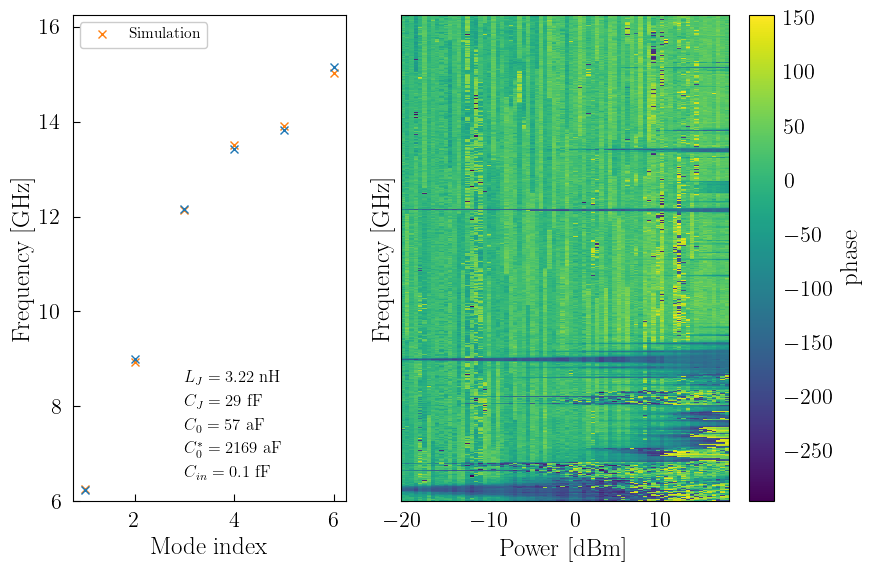

In [24]:
latex_style(True)
fig,ax=plt.subplots(1,2,figsize=(9,6),sharey=True,gridspec_kw={'width_ratios': [1, 1.5]})
index_modes2 = np.append(index_modes,7)

ax[0].plot(index_modes, jja_resonances(result.x)[1:len(resonances)+1]*1e-9, 'x', color='C1', label="Simulation")
ax[0].plot(index_modes, resonances, 'x', color='C0')
# ax[0].plot(index_modes_interpolate, resonance_model(index_modes_interpolate, *fit), '-',label='Analytical expression')
ax[0].text(3.0, 8.5, rf'$L_J = {np.round(result.x[0],2)}$ nH', fontsize=12, ha='left')
ax[0].text(3.0, 8.0, rf'$C_J = {int(result.x[1])}$ fF', fontsize=12, ha='left')
ax[0].text(3.0, 7.5, rf'$C_0 = {int(result.x[2])}$ aF', fontsize=12, ha='left')
ax[0].text(3.0, 7.0, rf'$C_0^* = {int(result.x[3]*1e3)}$ aF', fontsize=12, ha='left')
ax[0].text(3.0, 6.5, rf'$C_{{in}} = {int(result.x[4]*1000)/1000}$ fF', fontsize=12, ha='left')
ax[0].set_xlabel('Mode index')
ax[0].set_ylabel('Frequency [GHz]')
ax[0].legend(fontsize=11,loc='upper left')

plot3D(
    data_dict=data['tts_gain2'],
    x_key='gain',
    y_key='freq',
    z_key='phase',
    flatten_vertical=1,
    ax=ax[1],
    fig=fig,
    # vmax=50
    )
# ax[0].legend()
ax[1].set_ylabel('Frequency [GHz]')
ax[1].set_xlabel('Power [dBm]')
fig.tight_layout()
plt.show()

## Effects of $C_0^*$

In [ ]:
%matplotlib widget
fig,ax=plt.subplots(1,2,figsize=(10, 6),sharey=True)

ax[0].set_title(r'$C_{{in}} = 0$ aF')
C0big_vals = np.array([1e-3*result.x[2],1e-3*result.x[2]*10,1e-3*result.x[2]*50, 1e-3*result.x[2]*100])
y = np.tile(result.x,(4,1))
y[:,3] = C0big_vals
ax[0].plot(np.arange(1,10), jja_resonances(y[0])[1:10]*1e-9,'o-',label = r'$C_0^* = C_0$')
ax[0].plot(np.arange(1,10), jja_resonances(y[1])[1:10]*1e-9,'o-',label = r'$C_0^* = 10 C_0$')
ax[0].plot(np.arange(1,10), jja_resonances(y[2])[1:10]*1e-9,'o-',label = r'$C_0^* =  50 C_0$')
ax[0].plot(np.arange(1,10), jja_resonances(y[3])[1:10]*1e-9,'o-',label = r'$C_0^* = 100 C_0$')

ax[1].set_title(r'$C_0^* = C_0$')
y = np.tile(result.x,(4,1))
Cin_vals = np.array([result.x[4]/10,result.x[4]*1,result.x[4]*10, result.x[4]*100])
y[:,3] = result.x[2]*1e-3*np.ones_like(C0big_vals)
y[:,4] = Cin_vals
ax[1].plot(np.arange(1,10), jja_resonances(y[0])[1:10]*1e-9,'o-',label = r'$C_{in} = C_{in}^{fit} / 10$')
ax[1].plot(np.arange(1,10), jja_resonances(y[1])[1:10]*1e-9,'o-',label = r'$C_{in} = C_{in}^{fit}$')
ax[1].plot(np.arange(1,10), jja_resonances(y[2])[1:10]*1e-9,'o-',label = r'$C_{in} = 10 C_{in}^{fit}$')
ax[1].plot(np.arange(1,10), jja_resonances(y[3])[1:10]*1e-9,'o-',label = r'$C_{in} = 100 C_{in}^{fit}$')

for ax in ax.flatten():
    ax.legend()
    ax.set_ylabel('Frequency [GHz]')
    ax.set_xlabel('Index mode')
plt.show()

# Kerr terms

In [ ]:
Ljj_fit = result.x[0]*1e9
Cjj_fit = result.x[1]*1e15
Cg_fit = result.x[2]*1e18
Cg_big_fit = result.x[3]*1e15
Cin_fit = result.x[4]*1e15

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(9,5))
ax.plot(jja_eigensys(result.x, subset_by_index=[0,7])[1][:,1], label = r'$\psi_{{1}}$')
ax.plot(jja_eigensys(result.x, subset_by_index=[0,7])[1][:,2], label = r'$\psi_{{2}}$')
ax.plot(jja_eigensys(result.x, subset_by_index=[0,7])[1][:,3], label = r'$\psi_{{3}}$')
ax.plot(jja_eigensys(result.x, subset_by_index=[0,7])[1][:,4], label = r'$\psi_{{4}}$')
ax.legend()
ax.set_ylabel(r'$\psi_k$')
ax.set_xlabel('Node number')
fig.tight_layout()
plt.show()

In [38]:
C_to_Ec(103/12 * 1e-18) * 1e-9

2256.725746562228

In [34]:
0.367*138/(0.31*1.6)

102.10887096774194